In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
batch_size = 120
num_classes = 10
epochs = 50
latent_dim = 128

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)


discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Flatten(),
        
        layers.Dense(1),
    ],
    name="discriminator",
)

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
            
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}


In [7]:
discriminator = keras.models.load_model("../GAN/discriminator")
generator = keras.models.load_model("../GAN/generator")

In [8]:
cond_gan = GAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [ ]:
cond_gan.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
#cond_gan.fit(dataset, epochs=20)

In [ ]:

#cond_gan.save("GAN")
generator.save("generator")
discriminator.save("discriminator")

In [9]:
def generate_digit(n = 0):
    
    noise = np.random.randn(latent_dim)
    gen_input = tf.reshape(noise, (1, latent_dim))
    
    image = generator.predict(gen_input)
    image *= 256
    image = image.astype(np.uint8)
    image = image[0]
    
    fig = plt.figure
    plt.imshow(image, cmap='gray')
    plt.show()
    plt.close()
    
    return discriminator.predict(generator.predict(gen_input))

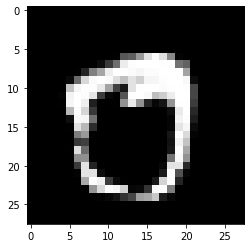

array([[0.26334107]], dtype=float32)

In [58]:
generate_digit()

In [60]:
def generate_good_digit(n = 0):
    
    
    while True:
        noise = np.random.randn(latent_dim)
        gen_input = tf.reshape(noise, (1, latent_dim))
        image = generator.predict(gen_input)
        if(abs(discriminator.predict(image)) < 0.1):
            break
    
    image *= 256
    image = image.astype(np.uint8)
    image = image[0]
    
    fig = plt.figure
    plt.imshow(image, cmap='gray')
    plt.show()
    plt.close()
    
    return discriminator.predict(generator.predict(gen_input))

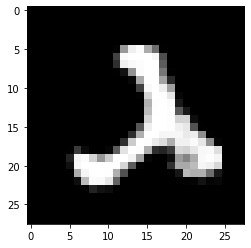

array([[0.06645215]], dtype=float32)

In [84]:
generate_good_digit()